# The best wind for a KOM on Strava
Two key aspects of the weather affect the time to complete a Strava segment: the wind and the air density. Both the speed and direction of the wind are important. When finessing a KOM, it is helpful to understand how temperature, pressure and humidity affect the air's density, as well as differences in altitude.<br>
Clearly, on an exposed, arrow-straight segment, the most favourable weather would be a hurricane tailwind. Like other KOM hunters, I have searched for segments that align with the predicted wind direction when a gale is forecast, though I've usually ended up going kitesurfing instead. <br>
When the segment is a loop, such as the <a href="https://www.strava.com/segments/610040" target="_blank">Tour de Richmond Park</a>, discussed in the previous blog, the question becomes more interesting. Consider a light aircraft flying above the Richmond Park segment at an altitude of 300m. Any constant wind, regardless of direction, will result in a slower time than completing the loop in still air. Why? Since any headwind slows down the plane, it hinders the pilot for more time than the tailwind provides assistance, resulting in a net increase in the total time.<br>
However, cyclists do not ride in constant winds. Trees, buildings and the terrain all affect the wind's speed and direction. The variability is so strong that it is recommended that multiple anenometers should be positioned at intervals alongside the 100m track at important athletics meetings. <br>
All this means that it is quite likely that there are optimal wind conditions for all Strava segments. Most people suggest that a tailwind up Sawyers Hill is best for Richmond Park - this would be just North of an Easterly, coming from a bearing of about 75&deg;. Historically, this is not a very common wind direction for London, especially when many PBs have been set, in July and August, though September has seen more frequent Easterlies. The following charts show the percentage frequency distributions of wind directions, for the year and for the summer months. (An interactive version can be found on <a href="https://www.windfinder.com/windstatistics/london-heathrow" target="_blank">this site</a>).

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import sys
sys.path.append('/Users/Gavin/Gavin/Jupyter/Weather')

from Windfinder import historicWind
historicWind = historicWind(location='london-heathrow')


In [2]:
def compassRose(Dirns,labels=[],saveto=False):
    """Make a compass rose radial chart from a set of equally-spaced Directions 
    in clockwise order from North and optionally saves to 'saveto'.png
    For multiple plots pass in vertically stacked arrays like 
    Dirns = np.vstack((segmentWindDirn,historicWind.Year))"""

    n = max(Dirns.shape)                                #  number of directions
    ax = plt.subplot(111, projection='polar')
    theta = 2 * np.pi * np.arange(n+1) / n         #  Since theta convention is anticlockwise...

    if Dirns.ndim == 1:    
        x = Dirns
        r = np.append(x[0],x[::-1])                   #  ...reverse order... 
        ax.plot(theta, r,label=labels[0])
    else:
        for i in range(Dirns.shape[0]):
            x = Dirns[i][:]
            r = np.append(x[0],x[::-1])                   #  reverse order... 
            ax.plot(theta, r, label=labels[i])
            
    ax.legend(loc='upper left', bbox_to_anchor=(0, 0.1),fontsize='small')
    ax.set_rlabel_position(-22.5)  # get radial labels away from plotted line
    ax.grid(True)
    ax.set_theta_zero_location("N")
#    ax.set_xticklabels(map(str, [0]+list(range(315,0,-45))))
    ax.set_xticklabels(['N','NW','W','SW','S','SE','E','NE']);
    ax.set_title('Frequency distribution of wind directions', va='bottom')
    if saveto:
        plt.savefig(saveto+'.png')
    plt.show()
    return


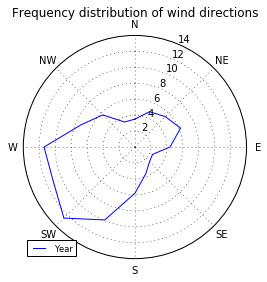

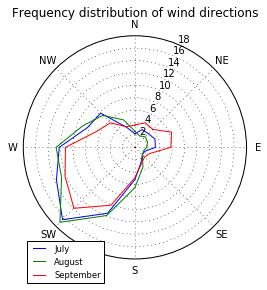

In [4]:
compassRose(historicWind.Year,['Year'],'RoseYear')
compassRose(np.vstack((historicWind.July,historicWind.August,historicWind.September)),['July','August','September'],'RoseSummer')



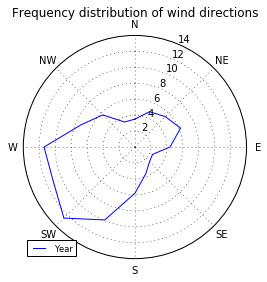

In [4]:
compassRose(historicWind.Year,['Year'])
plt.savefig('RoseYear.png')


Now, if the wind had no effect on the Strava segment, we would expect the distribution of wind directions on which riders set their PBs to be the same as the historic distribution. So we are interested in the *difference* between the distribution of wind directions on the dates derived from the leaderboard relative the background average.

## The following sections show workings
*First check how many dates we need to look up. We can almost, but not quite get this in one go with this call https://www.wunderground.com/history/airport/EGLL/2009/8/20/CustomHistory.html?dayend=20&monthend=2&yearend=2017&req_city=&req_state=&req_statename=&reqdb.zip=&reqdb.magic=&reqdb.wmo=&MR=1 but unfortunately it does not have the wind direction GRRR! This means I shall probably have to loop through the entire list, while complying with the user limits on the free licence*

In [5]:
LB = pd.read_pickle('/Users/Gavin/Gavin/jupyter/Strava/610040_LB.pkl')
LB.head()

,activity_id,athlete_gender,athlete_id,athlete_name,athlete_profile,average_hr,average_watts,distance,effort_id,elapsed_time,moving_time,rank,start_date_local
1,367579592,M,148510,Rob Sharland,https://dgalywyr863hv.cloudfront.net/pictures/...,NaN,392.9,10807.4,8778121649,00:13:57,00:13:57,1,2015-08-12 20:31:06
2,719686564,M,690619,richard mason,avatar/athlete/large.png,171.1,453.9,10943.6,17659926784,00:14:01,00:14:01,2,2016-09-21 06:34:30
3,719611363,M,442220,Barnabas Purbrook,https://dgalywyr863hv.cloudfront.net/pictures/...,177.8,389.8,10741.3,17658207678,00:14:02,00:14:02,3,2016-09-21 06:34:29
4,719856751,M,59039,Alexander Donaldson,https://dgalywyr863hv.cloudfront.net/pictures/...,157.0,314.9,10768.6,17663973529,00:14:02,00:14:02,3,2016-09-21 06:34:24
5,719598443,M,1457685,Tom Hargreaves,https://dgalywyr863hv.cloudfront.net/pictures/...,179.9,0.0,10803.4,17657927173,00:14:03,00:14:03,5,2016-09-21 06:34:26


In [6]:
# first check how many dates we need to look up
dateList = LB.start_date_local
print(len(dateList), dateList.min(), dateList.max())


1000 2009-08-22 09:07:21 2017-02-18 10:01:59


*Before resorting to WeatherUnderground, let's just try the old timanddate code I wrote, with the interpolation between six hourly observations. It turns out that this works fine*

In [7]:
import sys
sys.path.append('/Users/Gavin/Gavin/Jupyter/Weather')
from HistoricWeather import historicWeather, currentObs, weatherObs

def getObservations(dateList):
    observations = pd.DataFrame()
    for d in dateList:    
        [y, m, d, h, mi, s, town, country] = [d.year, d.month, d.day, d.hour, d.minute, d.second, 'london', 'uk']
        OBS = weatherObs(d=d, m=m, y=y, h=h, mi=mi, s=s, town=town, country=country)
        observations = observations.append(OBS)
    return observations

        
# **********Run this once, fill in gaps and then pickle*************
#observations = getObservations(dateList)


*Warning messages indicate that data for 2009 will be completed with average statistics. Manually look up statistic for missing dates from WeatherUnderground and insert them into the dataframe.*

In [8]:
#*******Run this once to fill in missing values and pickle**************
#reading = ['Date','Humidity','Pressure','Temp','Wind','WindDirn']
#missing = [['2009-08-22 09:07:21',72,1023,12,9.3/1.6,180],['2009-08-29 08:53:18',67,1022,9,20.4/1.6,270]]
#for m in missing:
#    for i,j in enumerate(m[1:]):
#        observations[reading[i+1]].loc[m[0]] = j

#observations.loc['2009']

#observations.to_pickle('610040_observations.pkl')

*I manually cross checked this data set against weatherundergound, to my satisfaction, so pickle the observations and take a look*

*OK let's import the previously cleaned-up, pickled observations and confirm that the dates match those in the the leaderboard*

In [9]:
observations = pd.read_pickle('610040_observations.pkl')
print('All dates match leaderboard: ',all(observations.index==LB.start_date_local))
observations.head()

All dates match leaderboard:  True


,Humidity,Pressure,Temp,Wind,WindDirn,AirDensity
2015-08-12 20:31:06,62.0,1022.0,21.0,11.0,80.0,1.202081
2016-09-21 06:34:30,85.0,1018.0,18.0,4.0,38.0,1.208711
2016-09-21 06:34:29,85.0,1018.0,18.0,4.0,38.0,1.208711
2016-09-21 06:34:24,85.0,1018.0,18.0,4.0,38.0,1.208711
2016-09-21 06:34:26,85.0,1018.0,18.0,4.0,38.0,1.208711


*This is the pandas merge command that appends the weather conditions to the leaderboard*

In [10]:
LB = pd.merge(LB,observations,left_on=['start_date_local'], right_index=True).drop_duplicates().sort_index()
LB.head()


,activity_id,athlete_gender,athlete_id,athlete_name,athlete_profile,average_hr,average_watts,distance,effort_id,elapsed_time,moving_time,rank,start_date_local,Humidity,Pressure,Temp,Wind,WindDirn,AirDensity
1,367579592,M,148510,Rob Sharland,https://dgalywyr863hv.cloudfront.net/pictures/...,NaN,392.9,10807.4,8778121649,00:13:57,00:13:57,1,2015-08-12 20:31:06,62.0,1022.0,21.0,11.0,80.0,1.202081
2,719686564,M,690619,richard mason,avatar/athlete/large.png,171.1,453.9,10943.6,17659926784,00:14:01,00:14:01,2,2016-09-21 06:34:30,85.0,1018.0,18.0,4.0,38.0,1.208711
3,719611363,M,442220,Barnabas Purbrook,https://dgalywyr863hv.cloudfront.net/pictures/...,177.8,389.8,10741.3,17658207678,00:14:02,00:14:02,3,2016-09-21 06:34:29,85.0,1018.0,18.0,4.0,38.0,1.208711
4,719856751,M,59039,Alexander Donaldson,https://dgalywyr863hv.cloudfront.net/pictures/...,157.0,314.9,10768.6,17663973529,00:14:02,00:14:02,3,2016-09-21 06:34:24,85.0,1018.0,18.0,4.0,38.0,1.208711
5,719598443,M,1457685,Tom Hargreaves,https://dgalywyr863hv.cloudfront.net/pictures/...,179.9,0.0,10803.4,17657927173,00:14:03,00:14:03,5,2016-09-21 06:34:26,85.0,1018.0,18.0,4.0,38.0,1.208711


*We can now look at the distribution of wind directions for the leaderboard. Using 16 bins aligned with the compass rose and subtracting (360/32) to achieve central alignment of bins.*

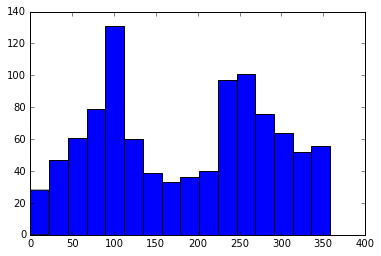

In [11]:
hist = plt.hist(LB.WindDirn.add(360/32).mod(360),bins=16)
segmentWindDirn = hist[0]/10

*Let's compare this with the windfinder.com data.*

<Container object of 16 artists>

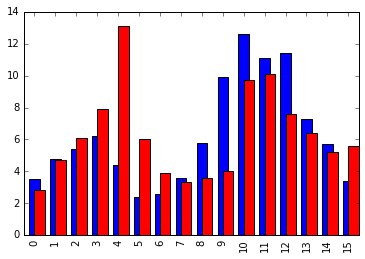

In [12]:
historicWind.Year.plot(kind='bar',width=0.5)
plt.bar(historicWind.index,segmentWindDirn,color='r',width=0.5)

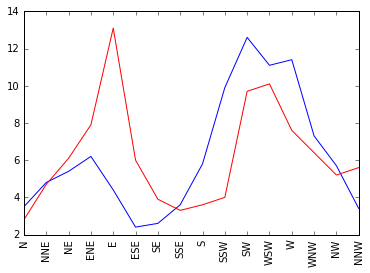

In [13]:
compass = ['N','NNE','NE','ENE','E','ESE','SE','SSE','S','SSW','SW','WSW','W','WNW','NW','NNW']
historicWind.Year.plot()
plt.xticks(range(16),compass,rotation='vertical')
plt.plot(historicWind.index,segmentWindDirn,color='r')

*This is the chi-squared test, comparing the histograms, which shows a signficant difference at 5% signficance level*

In [14]:
from scipy.stats import chisquare
chisquare(segmentWindDirn,historicWind.Year)

Power_divergenceResult(statistic=31.92943524760134, pvalue=0.0065820434813959258)

*Now back to the blog*

The following two chart compares the segment against the historic average annual average. The compass rose on the left shows a far higher fequency of PBs being set when 
the wind blows between the North and the East, and a relatively lower incidence in the opposite direction. The right hand chart "unwraps" the two curves to show the relative difference, which is statistically significant (p&lt;0.01). We conclude that the best wind direction for a PB around Richmond Park is indeed a tailwind up Sawyers Hill. And, you guessed it, this was the wind direction when Rob Sharlard achieved the current KOM.

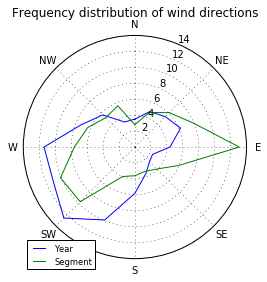

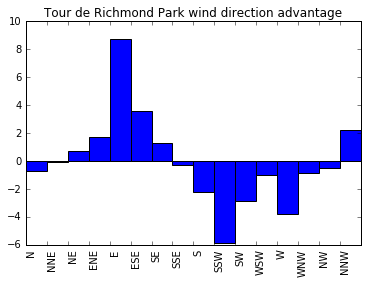

In [15]:
compassRose(np.vstack((historicWind.Year,segmentWindDirn)),['Year','Segment'],'RoseSegment')

windAdvantage = segmentWindDirn-historicWind.Year
plt.bar(historicWind.index,windAdvantage,color='b',width=1)
plt.title('Tour de Richmond Park wind direction advantage')
plt.xticks(range(16),compass,rotation=90,ha='left');
plt.savefig('BarSegment.png')


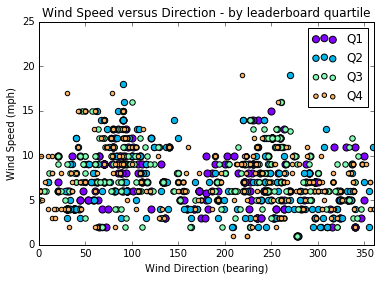

In [16]:
from matplotlib.pyplot import cm 
fig, ax = plt.subplots()
for label, df in LB.groupby((LB.index-1)//250):
    df.plot.scatter(x='WindDirn',y='Wind',ax=ax,color=cm.rainbow(label/4),label='Q'+str(label+1),s=50-label*10,xlim=(0,360),ylim=(0,25));
ax.set_title('Wind Speed versus Direction - by leaderboard quartile');
ax.set_ylabel('Wind Speed (mph)');
ax.set_xlabel('Wind Direction (bearing)');

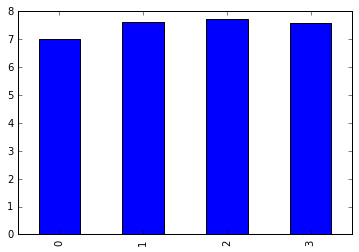

In [17]:
LB.Wind.groupby((LB.index-1)//250).mean().plot.bar()

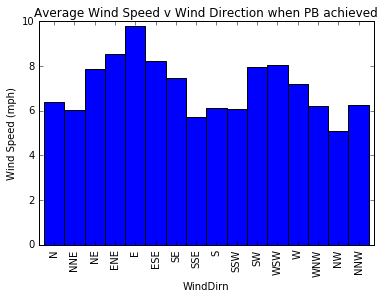

In [18]:
ax=LB.Wind.groupby((LB.WindDirn+360/32).mod(360)//(360/16)).mean().plot.bar(width=1)
plt.title('Average Wind Speed v Wind Direction when PB achieved')
plt.xticks(range(16),compass,rotation=90,ha='center');
ax.set_ylabel('Wind Speed (mph)')
plt.savefig('WindSpeedByDirn.png')


*Have a quick look at this plotted on compass rose - doesn't look that great*

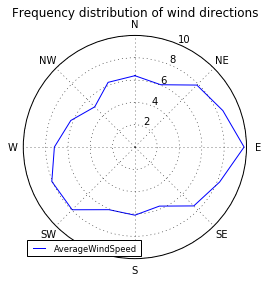

In [19]:
compassRose(LB.Wind.groupby((LB.WindDirn+360/32).mod(360)//(360/16)).mean(),['AverageWindSpeed'])

Read in QOM data

In [ ]:
LBF = pd.read_pickle('610040_LBF.pkl')

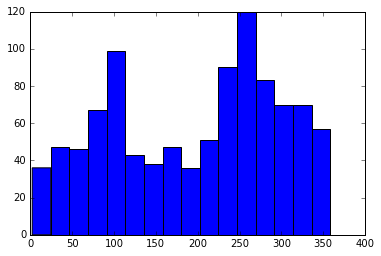

In [23]:
histF = plt.hist(LBF.WindDirn.add(360/32).mod(360),bins=16)
segmentWindDirnF = histF[0]/10

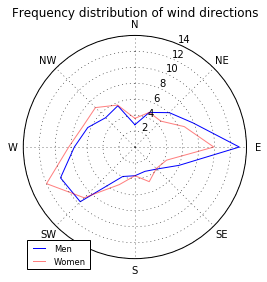

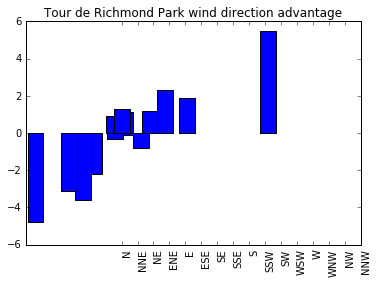

In [31]:
windAdvantageF = segmentWindDirnF-historicWind.Year


compassRose(np.vstack((segmentWindDirn,segmentWindDirnF)),['Men','Women'],'RoseSegment')
plt.savefig('WomenWindSpeedByDirn.png')

plt.bar(windAdvantage,windAdvantageF,color='b',width=1)
plt.title('Tour de Richmond Park wind direction advantage')
plt.xticks(range(16),compass,rotation=90,ha='left');
